# Sieci Neuronowe - kolokwium zaliczeniowe
### WSB-NLU, 2023-2024

Andrzej Kocielski

## Do zrobienia
Rozwiązanie zawierać ma elementy:
- wczytanie danych i krótki opis (5 pkt)
- przygotowanie danych do uczenia (5 pkt)
- trening sieci z komentarzem (5 pkt)
- tuning parametrów i ocena rozwiązania z komentarzem (5 pkt)
- porównanie z innym modelem ML (5 pkt), drugim innym modelem (+3pkt*)

Uwaga. Każdą fazę należy wydzielić i pokazać nie tylko kod, ale i screeny z testami działania.

Fragmenty kodu wykorzystane wcześniej do rozwiązania zadań na laboratoriach.

___
### Zaimportowanie bibliotek

In [1]:
# Imports

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ignore warnings
import warnings 
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pickle

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

from keras.models import Sequential # model of ANN
from keras.layers import Dense # layers of ANN

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

___
## Zadanie 1

Zbiór danych to CarPrices. 
Problem polega na predykcji ceny za pomocą sieci neuronowej zgodnie z wytycznymi powyżej.

### Załadowanie danych

Dane w postaci pliku `CarPricesData.pkl` znajdującym się w tym samym katalogu, co ten notatnik.

In [3]:
# Load dataset from file
CarPricesData = pd.read_pickle('CarPricesData.pkl')
# Data inspection
print(f"Shape of dataframe: {CarPricesData.shape}\n")
print(CarPricesData.info(), "\n")
print(CarPricesData.describe())

Shape of dataframe: (1435, 8)

<class 'pandas.core.frame.DataFrame'>
Index: 1435 entries, 0 to 1435
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1435 non-null   float64
 1   KM        1435 non-null   int64  
 2   Weight    1435 non-null   float64
 3   HP        1435 non-null   int64  
 4   MetColor  1435 non-null   int64  
 5   CC        1435 non-null   float64
 6   Doors     1435 non-null   int64  
 7   Price     1435 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 100.9 KB
None 

               Age             KM       Weight           HP     MetColor  \
count  1435.000000    1435.000000  1435.000000  1435.000000  1435.000000   
mean     56.027178   68571.782578  1071.659930   101.491986     0.674564   
std      18.532943   37491.094553    47.688509    14.981408     0.468701   
min       1.000000       1.000000  1000.000000    69.000000     0.000000   
25%      44.000000   43000.000000  1040

### Data cleaning
It appears there is some inaccurate data, e.g. with possible outliers in KM column.

All the records with KM = 1 will be removed (even though in some cases the Age = 1, which could be legitimate).

<AxesSubplot:ylabel='KM'>

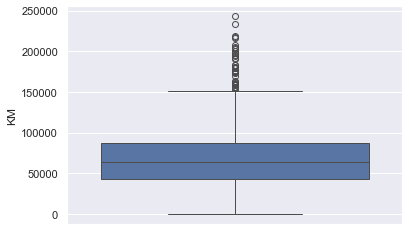

In [4]:
# Dubious data visualisation
sns.boxplot(CarPricesData["KM"])

In [5]:
# CarPricesData[CarPricesData["KM"] < 1000]
cleaned_data = CarPricesData[CarPricesData["KM"] != 1]
print(f"Removed rows: {CarPricesData.shape[0] - cleaned_data.shape[0]}")

Removed rows: 8


___
## Preparing the data

As the goal of this NN is to predict Price based on the other parameters, this information must be removed from the dataset destined for training the NN.

#### Separate outcome from predictors
Since the dataset already includes the outcome, that information should be separated from the other predictors for the training and validation of the NN.

In [6]:
# Separate Target Variable and Predictor Variables
TargetVariable = ['Price']
Predictors = ['Age', 'KM', 'Weight', 'HP', 'MetColor', 'CC', 'Doors']

X = cleaned_data[Predictors].values
y = cleaned_data[TargetVariable].values

#### Standardisation and fitting the values

Sandardization of data, using `StandardScaler` from sklearn.preprocessing library

In [7]:
# Set StandardScaler to both datasets
PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)

Split the data into training and testing sets, using method `train_test_split` from scikit-learn

In [8]:
# Split data into 70% training and 30% testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)
 
# Quick sanity check with the shapes of Training and testing datasets
print(f"Train inputs {X_train.shape}, train outputs {y_train.shape}")
print(f"Test inputs {X_test.shape}, test outputs {y_test.shape}")

Train inputs (998, 7), train outputs (998, 1)
Test inputs (429, 7), test outputs (429, 1)


## Build ANN

#### Neural Net model

For this exercise, `Sequential` model will be used, with consecutive layers of neurons. The net will be composed of the following layers:
1. Input layer
2. Hidden layers 
3. Output layer

The NN will be trained on the `training` subset, and validated on the `test` subset. 

The NN is charactrised with the following parameters:
- _activation function_ - specifies the activation function for the computations inside each neuron. 
- _loss function_ - specifies loss function that checks the prediction against the true value.
- _optimiser_ - used for minimizing the error, e.g. adaptive moment estimation (ADAM) 

#### Hyperparameters  

Hiperparameters as per exercise notes:  
- _units_ - this means that we are creating a layer with five neurons. Each of these five neurons will receive input values, for example the "Age" values will be passed to all five neurons, as will all other columns.
- _input_dim_ - this means that there are seven predictors in the input that are expected by the first layer. If you see a second dense layer, we do not specify this value because the sequential model passes this information on to subsequent layers.
- _kernel_initializer_ - when the neurons start computing, some algorithm must decide the value for each weight.
- _activation_ - specifies the activation function for the computations inside each neuron. 


Also, the entrie NN will be optimised, using the following hyperparameters:
- _batch_size_
- _epochs_ 

#### Evaluation
Quality (metrics) of the NN will be scored by evaluating the _accuracy_ of the model.

In [9]:
# create ANN model
model = Sequential()

# Building the layers of the net
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model; after the first layer we don't have to specify input_dim as keras configure it automatically
# model.add(Dense(units=10, kernel_initializer='normal', activation='relu'))

# The output neuron is a single fully connected node, since we will be predicting a single number
model.add(Dense(units=1, activation='relu'))

# Compiling the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# model info
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 40        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 46 (184.00 Byte)
Trainable params: 46 (184.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the model

In [10]:
# Fitting the ANN to the Training set
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=20,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/20
50/50 [==============================] - 1s 6ms/step - loss: 1.0069 - accuracy: 0.0000e+00 - val_loss: 0.7862 - val_accuracy: 0.0000e+00
Epoch 2/20
50/50 [==============================] - 0s 3ms/step - loss: 0.7754 - accuracy: 0.0000e+00 - val_loss: 0.5577 - val_accuracy: 0.0000e+00
Epoch 3/20
50/50 [==============================] - 0s 4ms/step - loss: 0.5700 - accuracy: 0.0000e+00 - val_loss: 0.4334 - val_accuracy: 0.0000e+00
Epoch 4/20
50/50 [==============================] - 0s 3ms/step - loss: 0.4533 - accuracy: 0.0000e+00 - val_loss: 0.3710 - val_accuracy: 0.0000e+00
Epoch 5/20
50/50 [==============================] - 0s 3ms/step - loss: 0.3933 - accuracy: 0.0000e+00 - val_loss: 0.3424 - val_accuracy: 0.0000e+00
Epoch 6/20
50/50 [==============================] - 0s 3ms/step - loss: 0.3645 - accuracy: 0.0000e+00 - val_loss: 0.3318 - val_accuracy: 0.0000e+00
Epoch 7/20
50/50 [==============================] - 0s 3ms/step - loss: 0.3510 - accuracy: 0.0000e+00 - val_loss

### Visualising the training progress

In practice, when training a model using frameworks like Keras or similar machine learning libraries, there are typically two datasets: the training set (_train_) and the validation set (_val_ or _validation_). Metrics values, such as accuracy (_accuracy_) or loss function (_loss_), are monitored on both the training and validation sets.  

In the code, `val_` is a prefix used to refer to the metric values on the validation (_test_) set during the training of the model. In this context, if `key1` is, for example, 'accuracy', then `'val_' + key1` denotes the accuracy on the validation set.  

Therefore, when using `history.history['val_' + key1]`, refers to the accuracy values on the validation set, and `history.history[key1]` refers to the accuracy values on the training set. 

In [11]:
def draw_curves(history, key1='accuracy', ylim1=(0.0, 1.0), key2='loss', ylim2=(0.0, 0.5)):
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history[key1], "r--")
    plt.plot(history.history['val_' + key1], "g--")
    plt.ylabel(key1)
    plt.xlabel('Epoch')
    plt.ylim(ylim1)
    plt.legend(['train', 'test'], loc='best')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history[key2], "r--")
    plt.plot(history.history['val_' + key2], "g--")
    plt.ylabel(key2)
    plt.xlabel('Epoch')
    plt.ylim(ylim2)    
    plt.legend(['train', 'test'], loc='best')
    
    plt.show()

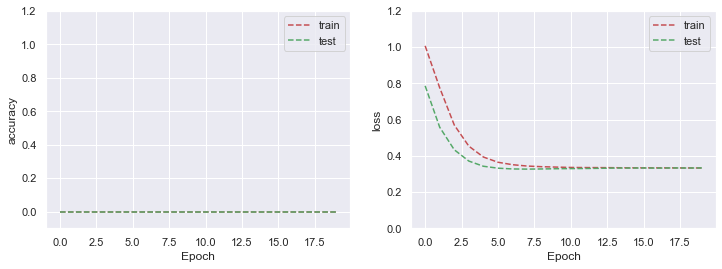

In [12]:
draw_curves(history, key1='accuracy', ylim1=(-0.1, 1.2), key2='loss', ylim2=(0.0, 1.2))

#### Scaling the results back to the orignal scale

In [13]:
# Generating Predictions on testing data
Predictions = model.predict(X_test)
# Scaling the predicted Price data back to original price scale
Predictions = TargetVarScalerFit.inverse_transform(Predictions)
Actuals = TargetVarScalerFit.inverse_transform(y_test)

# Print out actual vs predicted price for a few first test records
print()
for i in range(5):
    print(f"Actual price: {Actuals[i]}, prediction: {np.round(Predictions[i])}, difference: {Actuals[i]-np.round(Predictions[i])} ")

14/14 [==============================] - 0s 2ms/step

Actual price: [9950.], prediction: [10685.], difference: [-735.] 
Actual price: [8950.], prediction: [10685.], difference: [-1735.] 
Actual price: [18750.], prediction: [17266.], difference: [1484.] 
Actual price: [11650.], prediction: [12403.], difference: [-753.] 
Actual price: [18950.], prediction: [19253.], difference: [-303.] 


## Find the best parameters for the ANN
### Training the model

Further parameters for tuning the model:
- _batch_size_ - Specifies how many rows will be fed to the network at one time, after which calculation will begin and the neural network will begin to adjust its weights based on errors.
- _epochs_ - The same weight adjustment action is continued multiple times according to this parameter. To put it simply, the ANN looks at the full training data this many times and adjusts its weights.

In [16]:
def FindBestParams(X_train, y_train, X_test, y_test):
    """ 
    Function finds the best parameters for training the ANN.
    """    
    # Defining the list of hyper parameters to try
    batch_size_list = [5, 10, 20]
    epoch_list = [10, 20, 40]
    
    SearchResultsData = pd.DataFrame(columns=['TrialNumber', 'Parameters', 'MAPE', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            print()
            TrialNumber+=1
            
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=7, kernel_initializer='normal', activation='relu'))
            # Defining the Second layer of the model
            # model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
            # The output neuron 
            model.add(Dense(1))

            # Compiling the model
            model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
            
            # Fitting the ANN to the Training set
            history = model.fit(
                X_train, y_train,
                epochs=epochs_trial,
                batch_size=batch_size_trial,
                validation_data=(X_test, y_test),
                verbose=0,
                )

            MAPE = np.mean(100 * (np.abs(y_test - model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            # print(f"Trial {TrialNumber}, MAPE: {MAPE}")

            trial_result = pd.DataFrame(
                data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), MAPE, 100-MAPE]],
                            columns=['TrialNumber', 'Parameters', 'MAPE', 'Accuracy'])
            print(trial_result)

            SearchResultsData = pd.concat([SearchResultsData, trial_result], ignore_index=True)
            # SearchResultsData = SearchResultsData.append(trial_result)) # depricated in Pandas 2.0
    
    return(SearchResultsData)

In [17]:
# Calling the function
ResultsData = FindBestParams(X_train, y_train, X_test, y_test)

# Best accuracy
max_accuracy = ResultsData.loc[ResultsData['Accuracy'].idxmax()]
print(f"Best accuracy found: {max_accuracy[-1]:.3f}, with corresonding batch size and number of epochs: {max_accuracy[1]}.")


14/14 [==============================] - 0s 2ms/step
   TrialNumber Parameters       MAPE   Accuracy
0            1       5-10  14.922272  85.077728

14/14 [==============================] - 0s 2ms/step
   TrialNumber Parameters       MAPE   Accuracy
0            2       5-20  10.602912  89.397088

14/14 [==============================] - 0s 1ms/step
   TrialNumber Parameters      MAPE   Accuracy
0            3       5-40  6.072259  93.927741

14/14 [==============================] - 0s 2ms/step
   TrialNumber Parameters      MAPE  Accuracy
0            4      10-10  18.90151  81.09849

14/14 [==============================] - 0s 3ms/step
   TrialNumber Parameters       MAPE   Accuracy
0            5      10-20  12.481922  87.518078

14/14 [==============================] - 0s 2ms/step
   TrialNumber Parameters       MAPE   Accuracy
0            6      10-40  11.499559  88.500441

14/14 [==============================] - 0s 2ms/step
   TrialNumber Parameters       MAPE   Accuracy
0   

___
## Linear regression model

For comparison, linear regression model is used.

The same dataset and subsets are used (`X_train`, `X_test`, `y_train`, `y_test`).

In [18]:
# Quick sanity check with the shapes of Training and testing datasets
print(f"Train inputs {X_train.shape}, train outputs {y_train.shape}")
print(f"Test inputs {X_test.shape}, test outputs {y_test.shape}")

Train inputs (998, 7), train outputs (998, 1)
Test inputs (429, 7), test outputs (429, 1)


In [19]:
# create an instance of a LinearRegression() model named lin_reg_model.
lin_reg_model = LinearRegression()

#Train/fit lin_reg_model on the training data.
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [20]:
# calculate predictions
predictions = lin_reg_model.predict(X_test)

In [21]:
# accuracy of the linear regression model
MAPE_lr = np.mean(100 * (np.abs(y_test - predictions)/y_test))

print(f"Accuracy: {100 - MAPE_lr:.3f}") 

Accuracy: 97.791


## Findings

Both models were compared using Mean Absolute Percentage Error (MAPE) metrics.  
The formula for MAPE is:

$$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{A_i - F_i}{A_i} \right| \times 100\% $$

Where:  
$ n $ is the number of observations; 
$ A_i $ is the actual value; 
$ F_i $ is the forecasted (predicted) value.

Model accuracy is expressed as: $ 100\% - MAPE $

The following are the found accuracies of both models:

In [22]:
print(f"ANN accuracy:\t {max_accuracy[-1]:.3f}%")
print(f"LR accuracy:\t {100 - MAPE_lr:.3f}%")

ANN accuracy:	 93.928%
LR accuracy:	 97.791%


References:
- <https://www.analyticsvidhya.com/blog/2021/07/car-price-prediction-machine-learning-vs-deep-learning/>
- <https://www.kaggle.com/code/karan842/car-price-prediction-neural-network>
- <https://github.com/andkoc001/Machine-Learning-and-Statistics-Project>

___
## Zadanie 2
Zbiór danych `CIFAR10` został pobrany z adresu:  
[https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz/](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz/)

Zestaw ten zawiera obrazy RGB 32x32 w dziesięciu klasach, co jest przydatne do testowania modeli klasyfikacji obrazów. Istnieje dziesięć klas oznaczonych liczbami całkowitymi od 0 do 9. Zastosować odpowiedni model sieci neuronowej do przypisania obrazów do właściwych klas, rozwiązać zgodnie z wytycznymi wyżej.

### Załadowanie i przygotowanie danych

In [23]:
folder_cifar = r'cifar-10-batches-py'  # katalog, gdzie rozpakowałem pliki CIFAR-10

def unpickle(file):
    with open(file, 'rb') as fo:
        # dict = pickle.load(fo, encoding='latin1')
        dict = pd.read_pickle('data_batch_1')        
    return dict

# Lista plików w katalogu
pliki_cifar = os.listdir(folder_cifar)

# Inicjalizacja pustej listy na dane
wszystkie_dane = []

# Iteracja przez pliki i wczytanie danych
for plik_cifar in pliki_cifar:
    sciezka_do_pliku = os.path.join(folder_cifar, plik_cifar)
    dane_batch = unpickle(sciezka_do_pliku)
    # dane_batch = unpickle(plik_cifar)
    wszystkie_dane.append(dane_batch)

# Inicjalizacja pustej listy na dane
wszystkie_dane_sformatowane = []

# Iteracja przez listę słowników
for dane_batch in wszystkie_dane:
    wszystkie_dane_sformatowane.extend(dane_batch[b'data'])

# Tworzenie DataFrame
df = pd.DataFrame(wszystkie_dane_sformatowane)


FileNotFoundError: [Errno 2] No such file or directory: 'data_batch_1'

In [25]:
for dane_batch in wszystkie_dane:
    print(type(dane_batch))

In [26]:
wszystkie_dane[0][b'data']

IndexError: list index out of range

Ponieważ, mam trudności z dostępem do danych w plikach, zgodnie z rekomendacją na stronie, skąd pobrałem dane, podejmuję alternatywną metodę, tj. załadowanie danych bezpośrednio z pakietu TensorFlow.

In [27]:
from tensorflow.keras.datasets import cifar10
cifar = cifar10.load_data()

## Eksloracja danych

In [28]:
(train_images, train_labels), (test_images, test_labels) = cifar

# Wyświetlenie rozmiarów zbiorów
print("Rozmiary zbiorów:")
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Rozmiary zbiorów:
Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


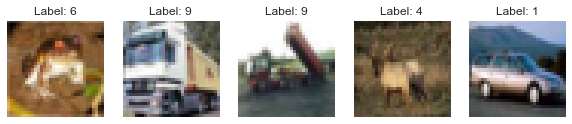

In [29]:
# Wyświetlenie przykładowych obrazów
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_images[i])
    plt.title(f"Label: {train_labels[i][0]}")
    plt.axis('off')
plt.show()

### Budowanie modelu sieci

In [30]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'), # wygaszone, żeby przyśpieszyć obliczenia na kolokwium
    # layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Trenowanie modelu
Tylko 5 epok, w celu ograniczenia czasu na obliczenia podczas kolokwium.

In [31]:
model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
1563/1563 [==============================] - 62s 39ms/step - loss: 2.5845 - accuracy: 0.2716 - val_loss: 1.6912 - val_accuracy: 0.3758
Epoch 2/5
1563/1563 [==============================] - 81s 52ms/step - loss: 1.5131 - accuracy: 0.4627 - val_loss: 1.3434 - val_accuracy: 0.5242
Epoch 3/5
1563/1563 [==============================] - 116s 74ms/step - loss: 1.2157 - accuracy: 0.5748 - val_loss: 1.2662 - val_accuracy: 0.5637
Epoch 4/5
1563/1563 [==============================] - 90s 58ms/step - loss: 1.0161 - accuracy: 0.6452 - val_loss: 1.2537 - val_accuracy: 0.5845
Epoch 5/5
1563/1563 [==============================] - 108s 69ms/step - loss: 0.8679 - accuracy: 0.6977 - val_loss: 1.2978 - val_accuracy: 0.5848


In [32]:
# Ewaluacja modelu na danych testowych
loss, accuracy = model.evaluate(test_images, test_labels)

# Wyświetlenie wyników
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 4s 14ms/step - loss: 1.2978 - accuracy: 0.5848
Loss: 1.2977803945541382
Accuracy: 0.5848000049591064


### Predykcja

In [33]:
# Uzyskanie predykcji dla danych testowych
predictions = model.predict(test_images)

# Ocenianie predykcji
from sklearn.metrics import accuracy_score

# Konwertowanie predykcji z postaci one-hot na jednowymiarową
predicted_labels = predictions.argmax(axis=1)

# Ocenianie dokładności
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 4s 13ms/step
Accuracy: 0.5848


___
Andrzej Kocielski